# Notebook for baseline models

In [1]:
# load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

from util_funcs import load_split_data, sentence_embeddings
from sentence_transformers import SentenceTransformer

from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.regularizers import l2
from keras.callbacks import EarlyStopping

In [2]:
# setup PyTorch backend
import os
os.environ['KERAS_BACKEND'] = 'torch'
import torch
print("Using PyTorch backend")
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Using device: {device}")

Using PyTorch backend
Using device: cuda


In [ ]:
# generate data splits
X_train, X_val, X_test, y_train, y_val, y_test = load_split_data("../data/Sentiment_Analysis.csv")

In [4]:
# generate sentence embeddings
emb_model = SentenceTransformer("all-MiniLM-L6-v2")
X_train_emb, X_val_emb, X_test_emb = sentence_embeddings((X_train, X_val, X_test), emb_model)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Batches:   0%|          | 0/750 [00:00<?, ?it/s]

Batches:   0%|          | 0/250 [00:00<?, ?it/s]

Batches:   0%|          | 0/250 [00:00<?, ?it/s]

Training embeddings shape: (24000, 384)
Validation embeddings shape: (8000, 384)
Test embeddings shape: (8000, 384)


## MLP

In [5]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

In [6]:
# model 1
mlp_1 = Sequential([
    Dense(16, activation='relu', input_shape=(384,)),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(13, activation='softmax')
])

mlp_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
mlp_1.summary()
mlp_1_history = mlp_1.fit(X_train_emb, y_train, validation_data=(X_val_emb, y_val), epochs=30, callbacks=[early_stop])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │         6,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 13)             │           221 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,925 (27.05 KB)

 Trainable params: 6,925 (27.05 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.2513 - loss: 2.1737 - val_accuracy: 0.3359 - val_loss: 1.9060
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3436 - loss: 1.8915 - val_accuracy: 0.3519 - val_loss: 1.8774
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3509 - loss: 1.8675 - val_accuracy: 0.3526 - val_loss: 1.8664
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3648 - loss: 1.8500 - val_accuracy: 0.3589 - val_loss: 1.8585
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3737 - loss: 1.8174 - val_accuracy: 0.3560 - val_loss: 1.8573
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3764 - loss: 1.8180 - val_accuracy: 0.3635 - val_loss: 1.8544
Epoch 7/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3799 - loss: 1.8018 - val_accuracy: 0.3624 - val_loss: 1.8517
Epoch 8/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3745 - loss: 1.8049 - val_accuracy: 0.

In [7]:
# model 2
mlp_2 = Sequential([
    Dense(16, activation='relu', input_shape=(384,)),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(13, activation='softmax')
])

mlp_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
mlp_2.summary()
mlp_2_history = mlp_2.fit(X_train_emb, y_train, validation_data=(X_val_emb, y_val), epochs=30, callbacks=[early_stop])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 16)             │         6,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 13)             │           221 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,197 (28.11 KB)

 Trainable params: 7,197 (28.11 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.2007 - loss: 2.3065 - val_accuracy: 0.2835 - val_loss: 2.0099
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2710 - loss: 2.0608 - val_accuracy: 0.3114 - val_loss: 1.9694
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2993 - loss: 2.0164 - val_accuracy: 0.3216 - val_loss: 1.9326
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3028 - loss: 2.0067 - val_accuracy: 0.3231 - val_loss: 1.9255
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3165 - loss: 1.9733 - val_accuracy: 0.3286 - val_loss: 1.9248
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3180 - loss: 1.9719 - val_accuracy: 0.3347 - val_loss: 1.9223
Epoch 7/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3243 - loss: 1.9509 - val_accuracy: 0.3366 - val_loss: 1.9163
Epoch 8/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3334 - loss: 1.9452 - val_accuracy: 0.

In [8]:
# model 3
mlp_3 = Sequential([
    Dense(16, activation='relu', input_shape=(384,)),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(13, activation='softmax')
])

mlp_3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
mlp_3.summary()
mlp_3_history = mlp_3.fit(X_train_emb, y_train, validation_data=(X_val_emb, y_val), epochs=30, callbacks=[early_stop])

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 16)             │         6,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 13)             │           221 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,469 (29.18 KB)

 Trainable params: 7,469 (29.18 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.1998 - loss: 2.2983 - val_accuracy: 0.3083 - val_loss: 1.9968
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2993 - loss: 2.0170 - val_accuracy: 0.3351 - val_loss: 1.9140
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3244 - loss: 1.9608 - val_accuracy: 0.3369 - val_loss: 1.9114
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3304 - loss: 1.9338 - val_accuracy: 0.3439 - val_loss: 1.8946
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3411 - loss: 1.9266 - val_accuracy: 0.3399 - val_loss: 1.8936
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3445 - loss: 1.9079 - val_accuracy: 0.3499 - val_loss: 1.8833
Epoch 7/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3472 - loss: 1.9173 - val_accuracy: 0.3478 - val_loss: 1.8826
Epoch 8/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3467 - loss: 1.9059 - val_accuracy: 0.

In [9]:
# model 4
mlp_4 = Sequential([
    Dense(16, activation='relu', input_shape=(384,)),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(13, activation='softmax')
])

mlp_4.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
mlp_4.summary()
mlp_4_history = mlp_4.fit(X_train_emb, y_train, validation_data=(X_val_emb, y_val), epochs=30, callbacks=[early_stop])

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 16)             │         6,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 13)             │           221 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,469 (29.18 KB)

 Trainable params: 7,469 (29.18 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.2383 - loss: 2.2387 - val_accuracy: 0.3185 - val_loss: 1.9581
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3168 - loss: 1.9682 - val_accuracy: 0.3372 - val_loss: 1.9214
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3261 - loss: 1.9421 - val_accuracy: 0.3436 - val_loss: 1.9068
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3404 - loss: 1.9202 - val_accuracy: 0.3509 - val_loss: 1.9026
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3472 - loss: 1.8926 - val_accuracy: 0.3509 - val_loss: 1.9009
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.3498 - loss: 1.8997 - val_accuracy: 0.3503 - val_loss: 1.8994
Epoch 7/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3563 - loss: 1.8839 - val_accuracy: 0.3517 - val_loss: 1.8979
Epoch 8/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3669 - loss: 1.8734 - val_accuracy: 0.

## XGBoost

In [10]:
# xgboost
xgb_model = xgb.XGBClassifier(n_estimators=500, learning_rate=0.1, max_depth=5, early_stopping_rounds=5)
xgb_model.fit(X_train_emb, y_train, eval_set=[(X_val_emb, y_val)], verbose=10)

[0]	validation_0-mlogloss:2.44595
[10]	validation_0-mlogloss:2.15179
[20]	validation_0-mlogloss:2.03691
[30]	validation_0-mlogloss:1.97927
[40]	validation_0-mlogloss:1.94719
[50]	validation_0-mlogloss:1.92891
[60]	validation_0-mlogloss:1.91653
[70]	validation_0-mlogloss:1.90784
[80]	validation_0-mlogloss:1.90311
[90]	validation_0-mlogloss:1.89897
[100]	validation_0-mlogloss:1.89724
[110]	validation_0-mlogloss:1.89595
[120]	validation_0-mlogloss:1.89588
[126]	validation_0-mlogloss:1.89664


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=5,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, ...)

In [11]:
xgb_history = xgb_model.evals_result()

## Plots

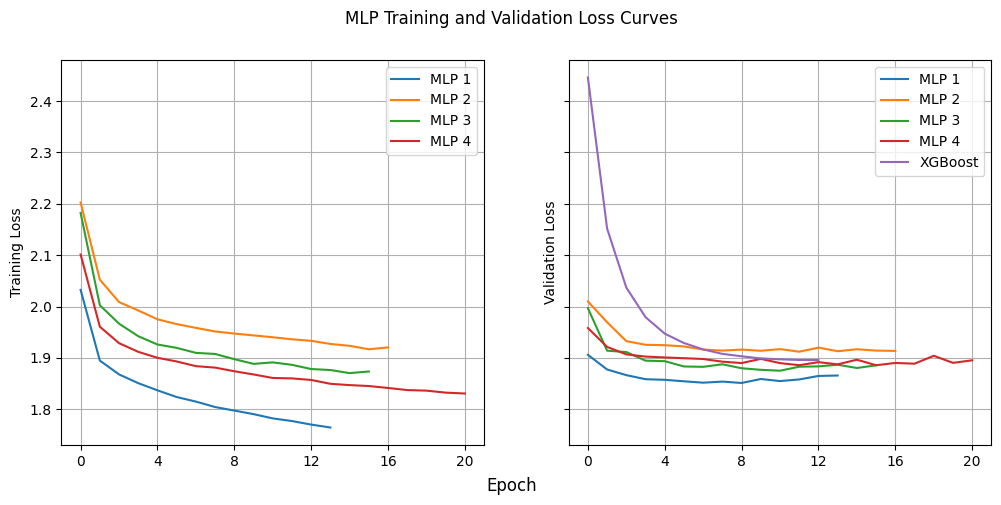

In [15]:
# mlp training/validation loss curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

ax1.plot(mlp_1_history.history['loss'], label='MLP 1')
ax1.plot(mlp_2_history.history['loss'], label='MLP 2')
ax1.plot(mlp_3_history.history['loss'], label='MLP 3')
ax1.plot(mlp_4_history.history['loss'], label='MLP 4')
ax1.legend()
ax1.set_xticks([i for i in range(21) if i % 4 == 0])
ax1.set_ylabel('Training Loss')
ax1.grid()

ax2.plot(mlp_1_history.history['val_loss'], label='MLP 1')
ax2.plot(mlp_2_history.history['val_loss'], label='MLP 2')
ax2.plot(mlp_3_history.history['val_loss'], label='MLP 3')
ax2.plot(mlp_4_history.history['val_loss'], label='MLP 4')
ax2.plot(xgb_history['validation_0']['mlogloss'][::10], label='XGBoost')
ax2.legend()
ax2.set_xticks([i for i in range(21) if i % 4 == 0])
ax2.set_ylabel('Validation Loss')
ax2.grid()

fig.suptitle('MLP Training and Validation Loss Curves')
fig.supxlabel('Epoch')
plt.show()

## Takeaways

- The MLP with no regularization/dropout had the best validation peformance despite overfitting to the training data
- Adding regularization/dropout successfully reduced overfitting but did not improve validation performance
- XGBoost performed comparably to the MLP models according to validation loss
- The best validation accuracy was about **36%** with loss around **1.85**, whereas a null model assigning everything to the majority class would give about **22%** accuracy